In [62]:
import numpy as np
import json
from collections import defaultdict, Counter
from scipy import spatial, stats
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

In [5]:
ROOT = '/data0/lucy/manosphere/'
DATA = ROOT + 'data/'
GLOVE = DATA + 'glove/'
LOGS = ROOT + 'logs/'
AGG_EMBED_PATH = LOGS + 'semantics_mano/agg_embed/'

## Inspecting individual words

In [6]:
with open(LOGS + 'semantics_mano/results/scores.json', 'r') as infile: 
    scores = json.load(infile) 

vocab_order = []
with open(LOGS + 'semantics_mano/results/vocab_order.txt', 'r') as infile:
    vocab_order = infile.readlines()

with open(LOGS + 'coref_results/mano_gender_labels.json', 'r') as infile: 
    gender_labels = json.load(infile)

In [7]:
word_poles = defaultdict(Counter) # {word : {pole : score}}
for pole in scores: 
    s = scores[pole]
    for i, term in enumerate(vocab_order): 
        term = term.strip()
        word_poles[term][pole] = s[i]

In [38]:
print(word_poles['alpha'].most_common()[:10])
print(word_poles['alpha'].most_common()[-10:])

[('covered.a.01', 0.25558773434051607), ('clothed.a.01', 0.20460857317052156), ('affected.a.01', 0.19743399192574534), ('busy.a.01', 0.19340250274625598), ('heavy.a.01', 0.1636908153666239), ('mature.a.01', 0.16354657637493), ('androgynous.a.02', 0.15458037457221652), ('delicate.a.01', 0.15350429755099337), ('experienced.a.01', 0.14051773941321305), ('limited.a.01', 0.14049881094011013)]
[('thick.a.01', -0.15037315269704593), ('right.a.04', -0.1534961767732639), ('upland.a.01', -0.15577203865108905), ('capitalistic.a.01', -0.16656310684758813), ('reasonable.a.01', -0.17066723676667722), ('enthusiastic.a.01', -0.17872971894421674), ('optimistic.a.01', -0.182795450552113), ('fat.a.01', -0.2067701379119683), ('moral.a.01', -0.2303085749221428), ('assertive.a.01', -0.26428843033663973)]


In [9]:
print(word_poles['beta'].most_common()[:10])
print(word_poles['beta'].most_common()[-10:])

[('clothed.a.01', 0.2302962468802881), ('busy.a.01', 0.22930095475453216), ('covered.a.01', 0.219025675618927), ('heavy.a.01', 0.20749793146852147), ('experienced.a.01', 0.20338786825387173), ('affected.a.01', 0.18867313060161872), ('active.a.03', 0.17924688026636332), ('visible.a.01', 0.17472462286340498), ('heavy.a.04', 0.16004797618931815), ('stressed.a.02', 0.15305906321978352)]
[('harmless.a.01', -0.1537984253997058), ('auspicious.a.01', -0.15603754767041586), ('quiet.a.02', -0.15667051373894447), ('capitalistic.a.01', -0.15725929069852884), ('defiant.a.01', -0.16001385997621265), ('assertive.a.01', -0.16640615169659442), ('pleasing.a.01', -0.17419947414924292), ('reasonable.a.01', -0.19200510196082082), ('moral.a.01', -0.19343655301123647), ('optimistic.a.01', -0.20350268094208734)]


In [10]:
print(word_poles['escort'].most_common()[:10])
print(word_poles['escort'].most_common()[-10:])

[('visible.a.01', 0.22309017709915227), ('tough.a.01', 0.213360012645474), ('settled.a.02', 0.19296624720667427), ('used.a.01', 0.1857999460473453), ('inclined.a.02', 0.1457751942450308), ('genuine.a.01', 0.144264839289096), ('heavy.a.04', 0.13563279490208444), ('mature.a.01', 0.12739001348117515), ('mindful.a.01', 0.12420469830860567), ('definite.a.01', 0.12353489816582765)]
[('enchanted.a.01', -0.1297488955033736), ('smooth.a.01', -0.13000566120988905), ('serviceable.a.01', -0.1453235611522138), ('east.a.01', -0.15217072046089813), ('assertive.a.01', -0.1561224887165856), ('optimistic.a.01', -0.1587276536999621), ('foreign.a.02', -0.16007725646172424), ('blond.a.01', -0.16609265606499185), ('enthusiastic.a.01', -0.17101999786777775), ('vertical.a.01', -0.1960913578840736)]


In [11]:
print(word_poles['wife'].most_common()[:10])
print(word_poles['wife'].most_common()[-10:])

[('stressed.a.02', 0.1642349879986019), ('communicative.a.02', 0.1548538037300795), ('shod.a.01', 0.1543340554310427), ('inclined.a.02', 0.147667724371479), ('used.a.01', 0.11680373567631179), ('nascent.a.01', 0.11622444489836678), ('practical.a.01', 0.11315294289782041), ('clothed.a.01', 0.11043103649144768), ('androgynous.a.02', 0.1101759594250323), ('worthy.a.01', 0.10829729959320025)]
[('prejudiced.a.02', -0.11483809209471618), ('refined.a.01', -0.11657568793466172), ('rural.a.01', -0.12230937551930993), ('sincere.a.01', -0.1348905506471321), ('enthusiastic.a.01', -0.14627547671047186), ('pleasing.a.01', -0.1476187306605714), ('vertical.a.01', -0.1505769589603431), ('indulgent.a.01', -0.17271745348962464), ('womanly.a.01', -0.2510947708161832), ('blond.a.01', -0.26228053180066013)]


In [12]:
print(word_poles['celebrities'].most_common()[:10])
print(word_poles['celebrities'].most_common()[-10:])

[('tough.a.01', 0.17081688060138467), ('heavy.a.04', 0.16985555976159045), ('shod.a.01', 0.16921350151419515), ('formal.a.01', 0.16257934295405002), ('rational.a.01', 0.1539584724003656), ('clearheaded.a.01', 0.15095418273110356), ('practical.a.01', 0.14949227852479552), ('used.a.01', 0.13713366262867435), ('functional.a.01', 0.13655726047751593), ('live.a.01', 0.13282821636469758)]
[('publicized.a.01', -0.16861678299034474), ('indulgent.a.01', -0.1689884056297398), ('fashionable.a.01', -0.17495802324450085), ('assertive.a.01', -0.1790488263955755), ('blond.a.01', -0.18400036903294198), ('honorable.a.02', -0.19386016991548416), ('capitalistic.a.01', -0.20089025110473818), ('enchanted.a.01', -0.2038839316617339), ('optimistic.a.01', -0.219878418645344), ('enthusiastic.a.01', -0.2702015404193948)]


In [13]:
print(word_poles['princes'].most_common()[:10])
print(word_poles['princes'].most_common()[-10:])

[('tough.a.01', 0.1805231952555273), ('present.a.01', 0.16453077107531805), ('modern.a.01', 0.1598416223346724), ('tough.a.03', 0.1524890905554785), ('used.a.01', 0.1516182763602973), ('surface.a.01', 0.1467284602966408), ('androgynous.a.02', 0.14105737420570597), ('shod.a.01', 0.13003690030581358), ('empirical.a.01', 0.12563998245363733), ('settled.a.02', 0.11645714677201925)]
[('refined.a.01', -0.15650710977105559), ('moral.a.01', -0.1566110449753308), ('glorious.a.01', -0.15852079714472445), ('assertive.a.01', -0.17072084941067336), ('rhetorical.a.02', -0.1747360461794557), ('honorable.a.02', -0.17498177536861484), ('auspicious.a.01', -0.1800081524016834), ('gracious.a.01', -0.190434756294191), ('pleasing.a.01', -0.19060802410015823), ('noble.a.02', -0.43068912052829506)]


In [14]:
print(word_poles['normies'].most_common()[:10])
print(word_poles['normies'].most_common()[-10:])

[('fragrant.a.01', 0.23376121381115872), ('clean.a.01', 0.23125052308491592), ('superior.a.01', 0.22022119417854905), ('educated.a.01', 0.21966800373108855), ('mindful.a.01', 0.2182822500174266), ('busy.a.01', 0.21826220544904631), ('settled.a.02', 0.21495180240785697), ('modest.a.01', 0.21196934804280826), ('careful.a.01', 0.20642503539056628), ('humorous.a.01', 0.20533699336294906)]
[('nonproprietary.a.01', -0.12804204739587602), ('wet.a.01', -0.13109088872897956), ('proud.a.01', -0.14986895208471712), ('moral.a.01', -0.1507341828212458), ('simple.a.01', -0.15215763433495405), ('conscious.a.02', -0.15456060351936168), ('prejudiced.a.02', -0.1595962284843616), ('selfish.a.01', -0.2134563069472661), ('ordinary.a.01', -0.23051900162149913), ('fat.a.01', -0.23554981095825875)]


In [15]:
print(word_poles['simps'].most_common()[:10])
print(word_poles['simps'].most_common()[-10:])

[('clean.a.01', 0.2604844388082124), ('serious.a.01', 0.2527842823082931), ('definite.a.01', 0.24164403889662878), ('conventional.a.04', 0.23772145187427085), ('abstemious.a.01', 0.22977715695462214), ('careful.a.01', 0.216644847990057), ('gracious.a.01', 0.21475233326039692), ('cautious.a.01', 0.21308335759125957), ('tasteful.a.01', 0.2048277942128987), ('busy.a.01', 0.20080071600078564)]
[('cheerful.a.01', -0.13711930530631397), ('flexible.a.02', -0.13992376426055217), ('quiet.a.01', -0.14082034815067648), ('flexible.a.01', -0.1432322652076855), ('nonproprietary.a.01', -0.1515342433042608), ('changeable.a.02', -0.15319182252356459), ('indulgent.a.01', -0.16091865765036034), ('simple.a.01', -0.17922892126620177), ('proud.a.01', -0.216327865672561), ('fat.a.01', -0.281288708181036)]


In [16]:
print(word_poles['prostitute'].most_common()[:10])
print(word_poles['prostitute'].most_common()[-10:])

[('used.a.01', 0.2738366691962819), ('clothed.a.01', 0.23937097872188579), ('settled.a.02', 0.2291109180309099), ('genuine.a.01', 0.20774164855996033), ('reputable.a.01', 0.2034176074242275), ('free.a.01', 0.20046270103216252), ('safe.a.01', 0.19728634455816058), ('superior.a.01', 0.18511084056671884), ('visible.a.01', 0.18354977985627313), ('careful.a.01', 0.1824616231531639)]
[('assertive.a.01', -0.1599361735706449), ('capitalistic.a.01', -0.16414326236623333), ('tired.a.01', -0.17383875787119737), ('optimistic.a.01', -0.17687235032425183), ('commercial.a.01', -0.18044915161152808), ('corrupt.a.01', -0.18965010845156033), ('womanly.a.01', -0.19693576109523947), ('blond.a.01', -0.1993103340935537), ('indulgent.a.01', -0.21088796861255577), ('prejudiced.a.02', -0.26173099058036536)]


In [17]:
print(word_poles['sweet girl'].most_common()[:10])
print(word_poles['sweet girl'].most_common()[-10:])

[('soured.a.01', 0.2993762680324553), ('old.a.01', 0.24585196920696173), ('large.a.01', 0.23454624090201942), ('demanding.a.01', 0.20686306185232417), ('busy.a.01', 0.197643275722586), ('distant.a.02', 0.189853979436521), ('used.a.01', 0.18674327001249796), ('tough.a.03', 0.1843033060276611), ('much.a.01', 0.1842825865919937), ('cursed.a.01', 0.17506098967106104)]
[('reasonable.a.01', -0.20029725604609822), ('sympathetic.a.04', -0.20576029865844586), ('exculpatory.a.01', -0.2085969624311667), ('refined.a.01', -0.22853918654971514), ('beautiful.a.01', -0.23545727870178343), ('sincere.a.01', -0.2519843280077457), ('optimistic.a.01', -0.2563437773193954), ('pleasing.a.01', -0.2725066810670002), ('kind.a.01', -0.2763736927813124), ('lovable.a.01', -0.3158886668571521)]


In [39]:
print(word_poles['thot'].most_common()[:10])
print(word_poles['thot'].most_common()[-10:])

[('definite.a.01', 0.1942506848860781), ('clean.a.01', 0.1673035189706998), ('improved.a.01', 0.16144572589832623), ('motivated.a.01', 0.152628178859815), ('conventional.a.04', 0.14834912226141417), ('assisted.a.01', 0.14402170982564783), ('gracious.a.01', 0.14375817406252167), ('exempt.a.01', 0.1386175631587233), ('meaningful.a.01', 0.1376077435672449), ('stable.a.01', 0.13545902803716559)]
[('strange.a.01', -0.10258656068959875), ('flexible.a.02', -0.10486797902865443), ('satisfactory.a.01', -0.11070000339932176), ('thinkable.a.01', -0.11700241756682321), ('credulous.a.01', -0.12267252067925646), ('fat.a.01', -0.12638101965574716), ('nonproprietary.a.01', -0.12937259858528127), ('old.a.02', -0.13903732562136084), ('same.a.01', -0.15038574864936355), ('distant.a.01', -0.20976531914767527)]


In [41]:
print(word_poles['women'].most_common()[:10])
print(word_poles['women'].most_common()[-10:])

[('stressed.a.02', 0.2689686041765973), ('androgynous.a.02', 0.26615011162215274), ('used.a.01', 0.17418508989923898), ('shod.a.01', 0.17415410665801528), ('heavy.a.04', 0.15623034942651035), ('clothed.a.01', 0.14830480731774676), ('worthy.a.01', 0.14272245389365118), ('resolute.a.01', 0.13329823016528006), ('sacred.a.01', 0.13287332282955855), ('protected.a.01', 0.12342149919623766)]
[('selfish.a.01', -0.12718445486502283), ('capitalistic.a.01', -0.12951324600671643), ('hot.a.03', -0.1325397538418296), ('graceful.a.01', -0.1355055651284687), ('pleasing.a.01', -0.13815785044580048), ('indulgent.a.01', -0.17790987421169782), ('shapely.a.01', -0.18686821149604158), ('prejudiced.a.02', -0.2406379872123752), ('blond.a.01', -0.32147493747143213), ('womanly.a.01', -0.5140653893774207)]


# Variance within gender

In [18]:
fem_variance = Counter() # {pole: variance of fem terms}
fem_extremes = defaultdict(tuple) # {pole: (top N terms, bottom N terms)}
masc_variance = Counter() 
masc_extremes = defaultdict(tuple)
fem_scores = defaultdict(list) # {pole: scores in order of x_words}
masc_scores = defaultdict(list) # {pole: scores in order of y_words}
N = 10
for pole in scores: 
    s = scores[pole]
    x = [] # fem scores
    x_words = []
    y = [] # masc scores
    y_words = []
    for i, term in enumerate(vocab_order): 
        term = term.strip()
        if term in gender_labels: 
            if gender_labels[term] > 0.75: 
                x.append(s[i])
                x_words.append(term)
            elif gender_labels[term] < 0.25: 
                y.append(s[i])
                y_words.append(term)
    fem_variance[pole] = np.var(x)
    indices = np.argpartition(x, -N)[-N:]
    topN = [x_words[idx].strip() for idx in indices]
    indices = np.argpartition(x, N)[:N]
    bottomN = [x_words[idx].strip() for idx in indices]
    fem_extremes[pole] = (topN, bottomN, min(x), max(x))
    fem_scores[pole] = x
    
    masc_variance[pole] = np.var(y)
    indices = np.argpartition(y, -N)[-N:]
    topN = [y_words[idx].strip() for idx in indices]
    indices = np.argpartition(y, N)[:N]
    bottomN = [y_words[idx].strip() for idx in indices]
    masc_extremes[pole] = (topN, bottomN, min(y), max(y))
    masc_scores[pole] = y

In [19]:
for tup in fem_variance.most_common(20): 
    print(tup)
    pole = tup[0]
    topN, bottomN, mi, ma = fem_extremes[pole]
    print("TOP:", topN)
    print("BOTTOM:", bottomN)
    print(mi, ma)
    print()

('womanly.a.01', 0.0207367739111438)
TOP: ['debbie downer', 'creepy stalker', 'harlot', 'fuckbuddy', 'harlots', 'tomboys', 'downer', 'hambeast', 'hambeasts', 'tomboy']
BOTTOM: ['female', 'feminine woman', 'female gender', 'feminine women', 'female feminist', 'women', 'feminist women', 'masculine women', 'women women', 'females']
-0.5856429849438389 0.36751912466938597

('androgynous.a.02', 0.01048472108047411)
TOP: ['1 female', 'black females', 'female', 'white females', 'female gender', 'female one', 'two females', 'females', 'more females', 'female humans']
BOTTOM: ['nympho', 'noodlewhores', 'noodlewhore', 'supermodel', 'supermodels', 'manipulative bitch', 'stepmom', 'harlots', 'harlot', 'tomboy']
-0.19918680740902128 0.4108695695846027

('lovable.a.01', 0.010376138902053338)
TOP: ['female supremacist', 'degenerate whores', 'protester', 'stupid cunts', 'woman hater', 'accusers', 'woman haters', 'false accusers', 'women haters', 'cunts']
BOTTOM: ['cute one', 'cute friend', 'sweet girl

In [20]:
for tup in masc_variance.most_common(20): 
    print(tup)
    pole = tup[0]
    topN, bottomN, mi, ma = masc_extremes[pole]
    print("TOP:", topN)
    print("BOTTOM:", bottomN)
    print(mi, ma)
    print()

('androgynous.a.02', 0.012188110400550777)
TOP: ['male members', 'male character', 'dominant male', 'white males', 'male players', 'one male', 'dominant males', 'masculine male', 'male', 'males']
BOTTOM: ['fucking hypocrites', 'hypocrite', 'fucking hypocrite', 'tenmagnet', 'manipulator', 'hypocrites', 'chiropractor', 'manipulators', 'charlatan', 'endocrinologist']
-0.2604874475023576 0.44170802824635863

('womanly.a.01', 0.01105276724502953)
TOP: ['introvert', 'introverted guy', 'faggots', 'little faggot', 'nutter', 'faggot', 'buffoon', 'goober', 'wimp', 'wanker']
BOTTOM: ['male gender', 'feminist man', 'feminine men', 'feminist leaders', 'male feminist', 'feminist men', 'male feminists', 'masculine male', 'male nurses', 'masculine men']
-0.5029534793157493 0.29910455279596726

('reputable.a.01', 0.009900774126213017)
TOP: ['chump', 'snitch', 'serial rapist', 'schmuck', 'misogynist', 'misogynists', 'mugger', 'muggers', 'wimp', 'wimps']
BOTTOM: ['great leader', 'successful people', 'goo

## Axes similarities for each clusters' highly gendered terms

In [22]:
with open(LOGS + 'gram_counts/combined_catyear_word_count.json', 'r') as infile: 
    catyear_word_count = json.load(infile)
total_vocab_count = Counter() # {term : count in mano reddit + forum}
for catyear in catyear_word_count: 
    for term in catyear_word_count[catyear]: 
        total_vocab_count[term] += catyear_word_count[catyear][term]
print(total_vocab_count.most_common(20))

[('she', 1760546), ('women', 1314942), ('people', 1092284), ('he', 861007), ('man', 829419), ('guys', 819044), ('girl', 789403), ('girls', 735912), ('men', 719274), ('guy', 684915), ('woman', 630001), ('someone', 545557), ('friends', 406592), ('anyone', 373798), ('friend', 338119), ('person', 332783), ('female', 295285), ('everyone', 287904), ('male', 248241), ('others', 217140)]


In [23]:
with open(LOGS + 'time_series/cluster_members_6.json', 'r') as infile: 
    clust_words = json.load(infile)
clust_words_rev = {}
for clust in clust_words: 
    cluster_words = clust_words[clust]
    for w in cluster_words: 
        clust_words_rev[w] = clust

In [29]:
cluster_gender_sum = defaultdict(Counter) # {gender + clust_num : {pole : sum of word scores} }
cluster_gender_total = defaultdict(Counter) # {gender + clust_num : {pole : word count} }
pole_sum = defaultdict(Counter) # {gender : {pole : sum of word scores} }
pole_count = defaultdict(Counter) # {gender : {pole : word count} }
for pole in scores: 
    s = scores[pole]
    for i, term in enumerate(vocab_order): 
        term = term.strip()
        clust_num = clust_words_rev[term]
        if term in gender_labels: 
            if gender_labels[term] > 0.75: 
                cluster_gender_sum[str(clust_num) + '_fem'][pole] += s[i]*total_vocab_count[term]
                cluster_gender_total[str(clust_num) + '_fem'][pole] += total_vocab_count[term]
                pole_sum['fem'][pole] += s[i]*total_vocab_count[term]
                pole_count['fem'][pole] += total_vocab_count[term]
            elif gender_labels[term] < 0.25: 
                cluster_gender_sum[str(clust_num) + '_masc'][pole] += s[i]*total_vocab_count[term]
                cluster_gender_total[str(clust_num) + '_masc'][pole] += total_vocab_count[term]
                pole_sum['masc'][pole] += s[i]*total_vocab_count[term]
                pole_count['masc'][pole] += total_vocab_count[term]
            else: 
                cluster_gender_sum[str(clust_num) + '_other'][pole] += s[i]*total_vocab_count[term]
                cluster_gender_total[str(clust_num) + '_other'][pole] += total_vocab_count[term]
                pole_sum['other'][pole] += s[i]*total_vocab_count[term]
                pole_count['other'][pole] += total_vocab_count[term]

In [30]:
cluster_gender_avg = defaultdict(Counter) 
for key in cluster_gender_sum: 
    for pole in cluster_gender_sum[key]: 
        if key.endswith('fem'): 
            pole_avg = pole_sum['fem'][pole] / pole_count['fem'][pole]
        elif key.endswith('masc'): 
            pole_avg = pole_sum['masc'][pole] / pole_count['masc'][pole]
        else: 
            continue
        cluster_gender_avg[key][pole] = cluster_gender_sum[key][pole] / cluster_gender_total[key][pole] - pole_avg

In [32]:
cluster_order = [4, 3, 5, 1, 2, 0]
common_shift_poles = Counter()
for clust_num in cluster_order: 
    for gender in ['fem', 'masc']:
        key = str(clust_num) + '_' + gender
        print(key)
        top = cluster_gender_avg[key].most_common()[:10]
        bottom = cluster_gender_avg[key].most_common()[-10:]
        for tup in top: 
            common_shift_poles[tup[0]] += 1
        for tup in bottom: 
            common_shift_poles[tup[0]] += 1
        print(top)
        print(bottom)
        print()

4_fem
[('inclined.a.01', 0.04459573565821398), ('prejudiced.a.02', 0.03713141165917774), ('indulgent.a.01', 0.0354813595789933), ('mobile.a.02', 0.03459343243948438), ('selfish.a.01', 0.03234095407198535), ('trustful.a.01', 0.03137506990775096), ('integrated.a.03', 0.030301170980960808), ('fallible.a.01', 0.030145502237779814), ('physical.a.01', 0.029980500369450224), ('worldly.a.01', 0.027994427351348373)]
[('cautious.a.01', -0.032740800509103773), ('stable.a.01', -0.033518829629303956), ('employed.a.01', -0.03420936086981716), ('finished.a.01', -0.035076466999820956), ('androgynous.a.02', -0.03950542177227791), ('settled.a.02', -0.04030867319800274), ('skilled.a.01', -0.041152187275028104), ('concerned.a.01', -0.041624956854472595), ('articulate.a.01', -0.042553841328825164), ('educated.a.01', -0.04340031989911078)]

4_masc
[('common.a.01', 0.024186440105667808), ('bright.a.01', 0.022514191757610734), ('womanly.a.01', 0.01884714430527166), ('delicate.a.01', 0.01760280183098603), ('de

In [36]:
common_shift_poles.most_common(30)

[('androgynous.a.02', 7),
 ('beautiful.a.01', 7),
 ('womanly.a.01', 6),
 ('conventional.a.04', 6),
 ('educated.a.01', 5),
 ('lively.a.01', 5),
 ('delicate.a.01', 4),
 ('old.a.01', 4),
 ('heavy.a.04', 4),
 ('lovable.a.01', 4),
 ('old.a.02', 4),
 ('prejudiced.a.02', 3),
 ('indulgent.a.01', 3),
 ('selfish.a.01', 3),
 ('lawful.a.01', 3),
 ('intellectual.a.02', 3),
 ('serious.a.01', 3),
 ('stressed.a.02', 3),
 ('sympathetic.a.04', 3),
 ('liked.a.01', 3),
 ('clean.a.01', 3),
 ('attractive.a.01', 3),
 ('punctual.a.01', 3),
 ('shod.a.01', 3),
 ('high.a.04', 3),
 ('shapely.a.01', 3),
 ('mobile.a.02', 2),
 ('physical.a.01', 2),
 ('settled.a.02', 2),
 ('skilled.a.01', 2)]

## Pole-specific analysis

Grouping and focusing on six poles. We choose poles using a combination of social theory (what has prior qualitative research deemed significant?) and the poles that quantitatively demonstrate large shifts across temporal clusters, as well as variance across highly gendered portions of the vocab. 

In [72]:
with open(LOGS + 'gram_counts/combined_catyear_word_count.json', 'r') as infile: 
    catyear_word_count = json.load(infile)
year_vocab_count = Counter() # {term_year : count in mano reddit + forum}
year_total = Counter() # {year: count}
for catyear in catyear_word_count: 
    year = catyear.split('_')[-1]
    for term in catyear_word_count[catyear]: 
        year_vocab_count[term + '_' + str(year)] += catyear_word_count[catyear][term]
        year_total[year] += catyear_word_count[catyear][term]
print(year_vocab_count.most_common(20))

[('women_2018', 369866), ('she_2018', 301291), ('she_2017', 240165), ('she_2019', 199792), ('people_2017', 197630), ('men_2017', 193478), ('women_2013', 193394), ('man_2018', 188619), ('guys_2018', 170581), ('he_2018', 162905), ('she_2012', 156226), ('man_2019', 154279), ('people_2019', 152824), ('women_2016', 138224), ('woman_2018', 134743), ('people_2018', 125745), ('people_2016', 119724), ('guy_2018', 119340), ('she_2016', 117969), ('people_2015', 117024)]


In [46]:
# to group together
attractive_poles = ['beautiful.a.01', 'lovable.a.01', 'attractive.a.01']
intelligence_poles = ['educated.a.01', 'intellectual.a.02']
age_poles = ['old.a.02', 'old.a.01']
# to analyze each separately
other_poles = ['prejudiced.a.02', 'heavy.a.04', 'clean.a.01'] 
poles_of_interest = intelligence_poles + attractive_poles + age_poles + other_poles

In [44]:
with open(LOGS + 'wikipedia/substitutes/bert-base-prob/word_rep_key.json', 'r') as infile: 
    word_rep_key = json.load(infile) # words that make up each pole

In [51]:
for key in word_rep_key: 
    parts = key.split('_')
    pole = parts[0]
    side = parts[1]
    adjs = set()
    if pole in poles_of_interest: 
        idx_list = word_rep_key[key]
        for item in idx_list: 
            adjs.add(item[1])
        print(key, adjs)
        print()

educated.a.01_right {'unlearned', 'untutored', 'unschooled', 'uneducated', 'undereducated', 'unstudied', 'unlettered', 'illiterate'}

educated.a.01_left {'semiliterate', 'well-read', 'learned', 'educated', 'lettered', 'well-educated', 'knowing', 'knowledgeable', 'self-educated', 'literate'}

clean.a.01_left {'clean', 'unstained', 'unused', 'spick', 'cleanly', 'pristine', 'unspotted', 'spic', 'scrubbed', 'immaculate', 'fresh', 'spotless', 'unsullied', 'washed'}

beautiful.a.01_left {'ravishing', 'sightly', 'stunning', 'pretty', 'beautiful', 'handsome', 'good-looking', 'resplendent', 'lovely', 'picturesque', 'bonnie', 'comely', 'gorgeous', 'fair', 'glorious', 'splendid', 'scenic', 'exquisite'}

old.a.01_right {'girlish', 'junior', 'four-year-old', 'tender', 'childlike', 'preteen', 'infantile', 'vernal', 'youthful', 'five-year-old', 'newborn', 'three-year-old', 'young', 'adolescent', 'teenaged', 'early', 'little', 'teenage', 'teen', 'immature', 'one-year-old', 'two-year-old', 'small', 'bo

In [56]:
df = pd.read_csv(LOGS + 'semantics_mano/results/specific_scores.csv', index_col=0)

In [57]:
df

,word,year,cosine similarity,axis
0,0 friends,2011,-0.131684,attractive.a.01
1,0 friends,2012,-0.094343,attractive.a.01
2,0 friends,2013,-0.120177,attractive.a.01
3,0 friends,2014,-0.121840,attractive.a.01
4,0 friends,2015,-0.125060,attractive.a.01
...,...,...,...,...
692925,zombies,2015,-0.218082,prejudiced.a.02
692926,zombies,2016,-0.211253,prejudiced.a.02
692927,zombies,2017,-0.157223,prejudiced.a.02
692928,zombies,2018,-0.091992,prejudiced.a.02


In [92]:
year_total

Counter({'2017': 4542508,
         '2015': 3357518,
         '2014': 2756047,
         '2016': 3119766,
         '2013': 2255214,
         '2019': 3893416,
         '2012': 1921556,
         '2018': 6703033,
         '2010': 1175103,
         '2011': 1424266,
         '2009': 958820,
         'None': 8354,
         '2008': 913910,
         '2007': 650128,
         '2006': 592316,
         '2005': 18364,
         '1970': 11})

In [113]:
def weighted_mean(x):
    return x[0]
df.columns = [c.replace(' ', '_') for c in df.columns]
df['word_year'] = df['word'] + '_' + df['year'].map(str)
df['weight'] = df['word_year'].apply(lambda x: year_vocab_count[x])
df['year_total'] = df['year'].apply(lambda x: year_total[str(x)])
df["cosine_and_weight"] = list(zip(df.cosine_similarity, df.weight, df.year_total))
df

,word,year,cosine_similarity,axis,word_year,weight,cosine_and_weight,year_total
0,0 friends,2011,-0.131684,attractive.a.01,0 friends_2011,11,"(-0.1316839568967145, 11, 1424266)",1424266
1,0 friends,2012,-0.094343,attractive.a.01,0 friends_2012,22,"(-0.0943429922726944, 22, 1921556)",1921556
2,0 friends,2013,-0.120177,attractive.a.01,0 friends_2013,20,"(-0.1201773517688611, 20, 2255214)",2255214
3,0 friends,2014,-0.121840,attractive.a.01,0 friends_2014,48,"(-0.1218398565938156, 48, 2756047)",2756047
4,0 friends,2015,-0.125060,attractive.a.01,0 friends_2015,81,"(-0.1250603156319957, 81, 3357518)",3357518
...,...,...,...,...,...,...,...,...
692925,zombies,2015,-0.218082,prejudiced.a.02,zombies_2015,411,"(-0.2180822800076584, 411, 3357518)",3357518
692926,zombies,2016,-0.211253,prejudiced.a.02,zombies_2016,462,"(-0.2112529911772137, 462, 3119766)",3119766
692927,zombies,2017,-0.157223,prejudiced.a.02,zombies_2017,561,"(-0.157222732501829, 561, 4542508)",4542508
692928,zombies,2018,-0.091992,prejudiced.a.02,zombies_2018,649,"(-0.0919918759485654, 649, 6703033)",6703033


In [88]:
attractive_df = df[df['axis'].isin(attractive_poles)]
intelligence_df = df[df['axis'].isin(intelligence_poles)]
age_df = df[df['axis'].isin(age_poles)]
pole_title_map = {
    'prejudiced.a.02': 'discriminatory', 
    'heavy.a.04': 'distressful',
    'clean.a.01': 'clean',
}
other_df = []
for pole in other_poles: 
    this_df = df[df['axis'] == pole]
    other_df.append((this_df, pole))

TypeError: Invalid object type at position 0

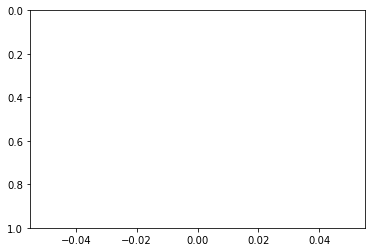

In [114]:
g = sns.lineplot(data=attractive_df, x="year", y="cosine_and_weight", hue='axis', ci=None, estimator=weighted_mean)
g.set_axis_labels("year", "cosine similarity")
plt.show()

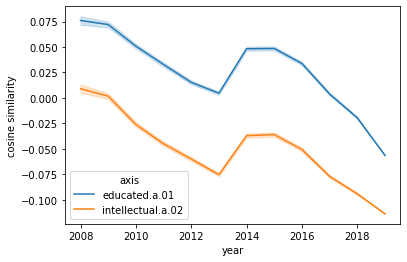

In [66]:
sns.lineplot(data=intelligence_df, x="year", y="cosine similarity", hue='axis', ci=None)
plt.show()

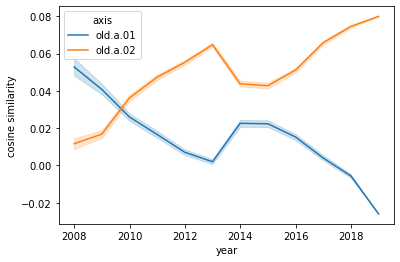

In [67]:
sns.lineplot(data=age_df, x="year", y="cosine similarity", hue='axis', ci=None)
plt.show()

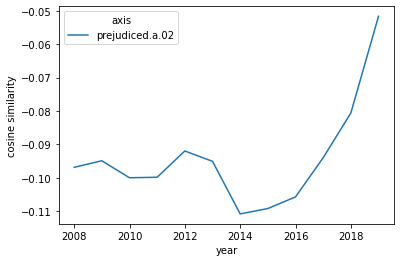

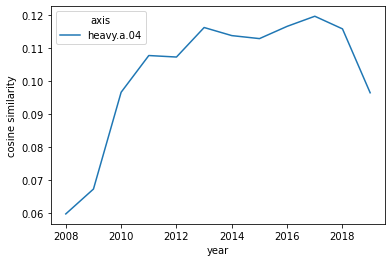

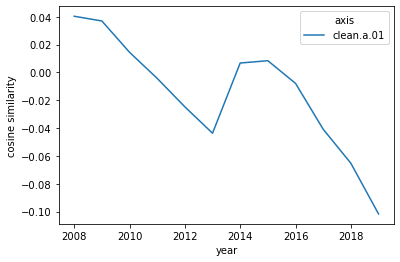

In [70]:
for tup in other_df: 
    this_df = tup[0]
    sns.lineplot(data=this_df, x="year", y="cosine similarity", hue='axis', ci=None)
    plt.show()